## Post-Thesis Analysis
1. For each comparison log, what percentage of queries (deduplicated) are exactly the same as those contained in the AQL (once case-sensitive, once case-insensitive)?
2. What percentage of all queries (deduplicated) are exactly the same as those contained in at least one of the comparison logs (case-sensitive/case-insensitive)?
3. Regarding the experiments from 1., what is the situation per year? (The year(s) in which the respective comparison log was crawled is particularly interesting.)

In [82]:
from pathlib import Path
import json
from model import AnalysisName, DatasetName
from typing import Iterable, Dict, Any

def load_results(analysis_name: AnalysisName, dataset_name: DatasetName) -> Iterable[Dict[str, Any]]:
    results_folder = f"{dataset_name}-{analysis_name}"
    if analysis_name in ['count-deduplicated-queries', 'count-deduplicated-lowercase-queries']:
        path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/results")
    else:
        results_folder += "-all"
        path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/")
    
    path = path.joinpath(results_folder)
    assert path.exists(), f"Path {path} does not exist."
    # check if files inside path are json or jsonl and load accordingly
    files = []
    files.extend([file for file in path.glob("*.jsonl")])
    files.extend([file for file in path.glob("*.json")])
    if not files or all(file.suffix not in [".jsonl", ".json"] for file in files):
        raise ValueError(f"No JSON or JSONL files found in the specified path. Files found: {[file for file in path.glob('*')]}")
    data_list = []
    if files[0].suffix == ".jsonl":
        for file in files:
            with file.open("r") as f:
                data = f.readlines()
                for line in data:
                    if line.strip():
                        line = json.loads(line.strip())
                        data_list.append(line)   
    elif files[0].suffix == ".json":
        for file in files:
            with file.open("r") as f:
                data_list.append(json.load(f))
    else: 
        raise ValueError("Unsupported file format")
    return data_list

analyses = []
analyses.append("count-regular")
analyses.append("count-lowercase")
# analyses.append("count-deduplicated-queries")
# analyses.append("count-deduplicated-lowercase-queries")

dataset_name = ['aql-aol', 'aql-ms-marco', 'aql-orcas']
if "count-deduplicated-lowercase-queries" in analyses or "count-deduplicated-queries" in analyses:
    dataset_name.append('aql-aol-ms-marco-orcas')

data_dict = {}
for analysis_name in analyses:
    data_list = []
    data_dict[analysis_name] = data_list


    for dataset in dataset_name:
        data = load_results(analysis_name, dataset)
        data_list.extend(data)

print(data_dict)

{'count-regular': [{'aql-agg': 0.0, 'combined-agg': 10132779.910459856, 'compare-agg': 10132779.910459856, 'aql_agg+comp_agg-combined_agg': 0.0, 'duplicate-ratio-aql': 'ratio not defined (AQL agg < 1)', 'duplicate-ratio-comp': [0.0, '0.00%'], 'year': 1998, 'dataset': 'aql-aol', 'analysis_name': 'count-regular'}, {'aql-agg': 20328.677060308808, 'combined-agg': 10149404.816044254, 'compare-agg': 10132779.910459856, 'aql_agg+comp_agg-combined_agg': 3703.771475909278, 'duplicate-ratio-aql': [0.1821944175177435, '18.22%'], 'duplicate-ratio-comp': [0.00036552372681912813, '0.04%'], 'year': 1999, 'dataset': 'aql-aol', 'analysis_name': 'count-regular'}, {'aql-agg': 571650.7837063844, 'combined-agg': 10597252.206914179, 'compare-agg': 10132779.910459856, 'aql_agg+comp_agg-combined_agg': 107178.48725206032, 'duplicate-ratio-aql': [0.1874894433926118, '18.75%'], 'duplicate-ratio-comp': [0.010577402075162239, '1.06%'], 'year': 2000, 'dataset': 'aql-aol', 'analysis_name': 'count-regular'}, {'aql-ag

In [83]:

# preprocess
result_dict = {}
for analysis_name in analyses:
    result_dict[analysis_name] = {}
    if analysis_name == "count-deduplicated-lowercase-queries" or analysis_name == "count-deduplicated-queries":
        for i, data in enumerate(data_dict[analysis_name]):
            if i < len(data_dict[analysis_name]) - 1:
                result_dict[analysis_name][data['dataset_name'][1]] = round(data['intersec_ratio'], 5)
            if i == len(data_dict[analysis_name]) - 1:
                result_dict[analysis_name]['combined'] = round(data['intersec_ratio_comb'], 5)
                # result_dict[analysis_name]['aql_in_combined'] = round(data['intersec_ratio_aql'], 5)
    else:
        datasets = []
        for i,data in enumerate(data_dict[analysis_name]):
            if data['dataset'] not in datasets:
                result_dict[analysis_name][data['dataset']] = {}
                datasets.append(data['dataset'])
            if data['year'] >= 1999:
                result_dict[analysis_name][data['dataset']][data['year']] = [round(data['duplicate-ratio-aql'][0], 5), round(data['duplicate-ratio-comp'][0], 5)]

print(result_dict)

{'count-regular': {'aql-aol': {1999: [0.18219, 0.00037], 2000: [0.18749, 0.01058], 2001: [0.15547, 0.00254], 2002: [0.11989, 0.00352], 2003: [0.06592, 0.0015], 2004: [0.1541, 0.0011], 2005: [0.00384, 0.00012], 2006: [0.0902, 0.00412], 2007: [0.10078, 0.00504], 2008: [0.08219, 0.00438], 2009: [0.0355, 0.00386], 2010: [0.01062, 0.00137], 2011: [0.04265, 0.0069], 2012: [0.03129, 0.00654], 2013: [0.03281, 0.01129], 2014: [0.03062, 0.00993], 2015: [0.04002, 0.01362], 2016: [0.05037, 0.01477], 2017: [0.02678, 0.01327], 2018: [0.00411, 0.0013], 2019: [0.00105, 0.00113], 2020: [0.00308, 0.00367], 2021: [0.01328, 0.01865], 2022: [-0.00342, -0.00468]}, 'aql-ms-marco': {1999: [-0.03783, -8e-05], 2000: [-0.00202, -0.00013], 2001: [-0.00285, -5e-05], 2002: [-0.01588, -0.00051], 2003: [-0.02008, -0.0005], 2004: [0.03963, 0.00031], 2005: [-0.01717, -0.00061], 2006: [0.01666, 0.00084], 2007: [-0.04633, -0.00256], 2008: [0.04302, 0.00253], 2009: [-0.01164, -0.0014], 2010: [-0.01711, -0.00244], 2011: [0

/home/benjamin/studium/master/masterarbeit/thesis-schneg/plots/count-deduplicated-queries-AND-count-deduplicated-lowercase-queries


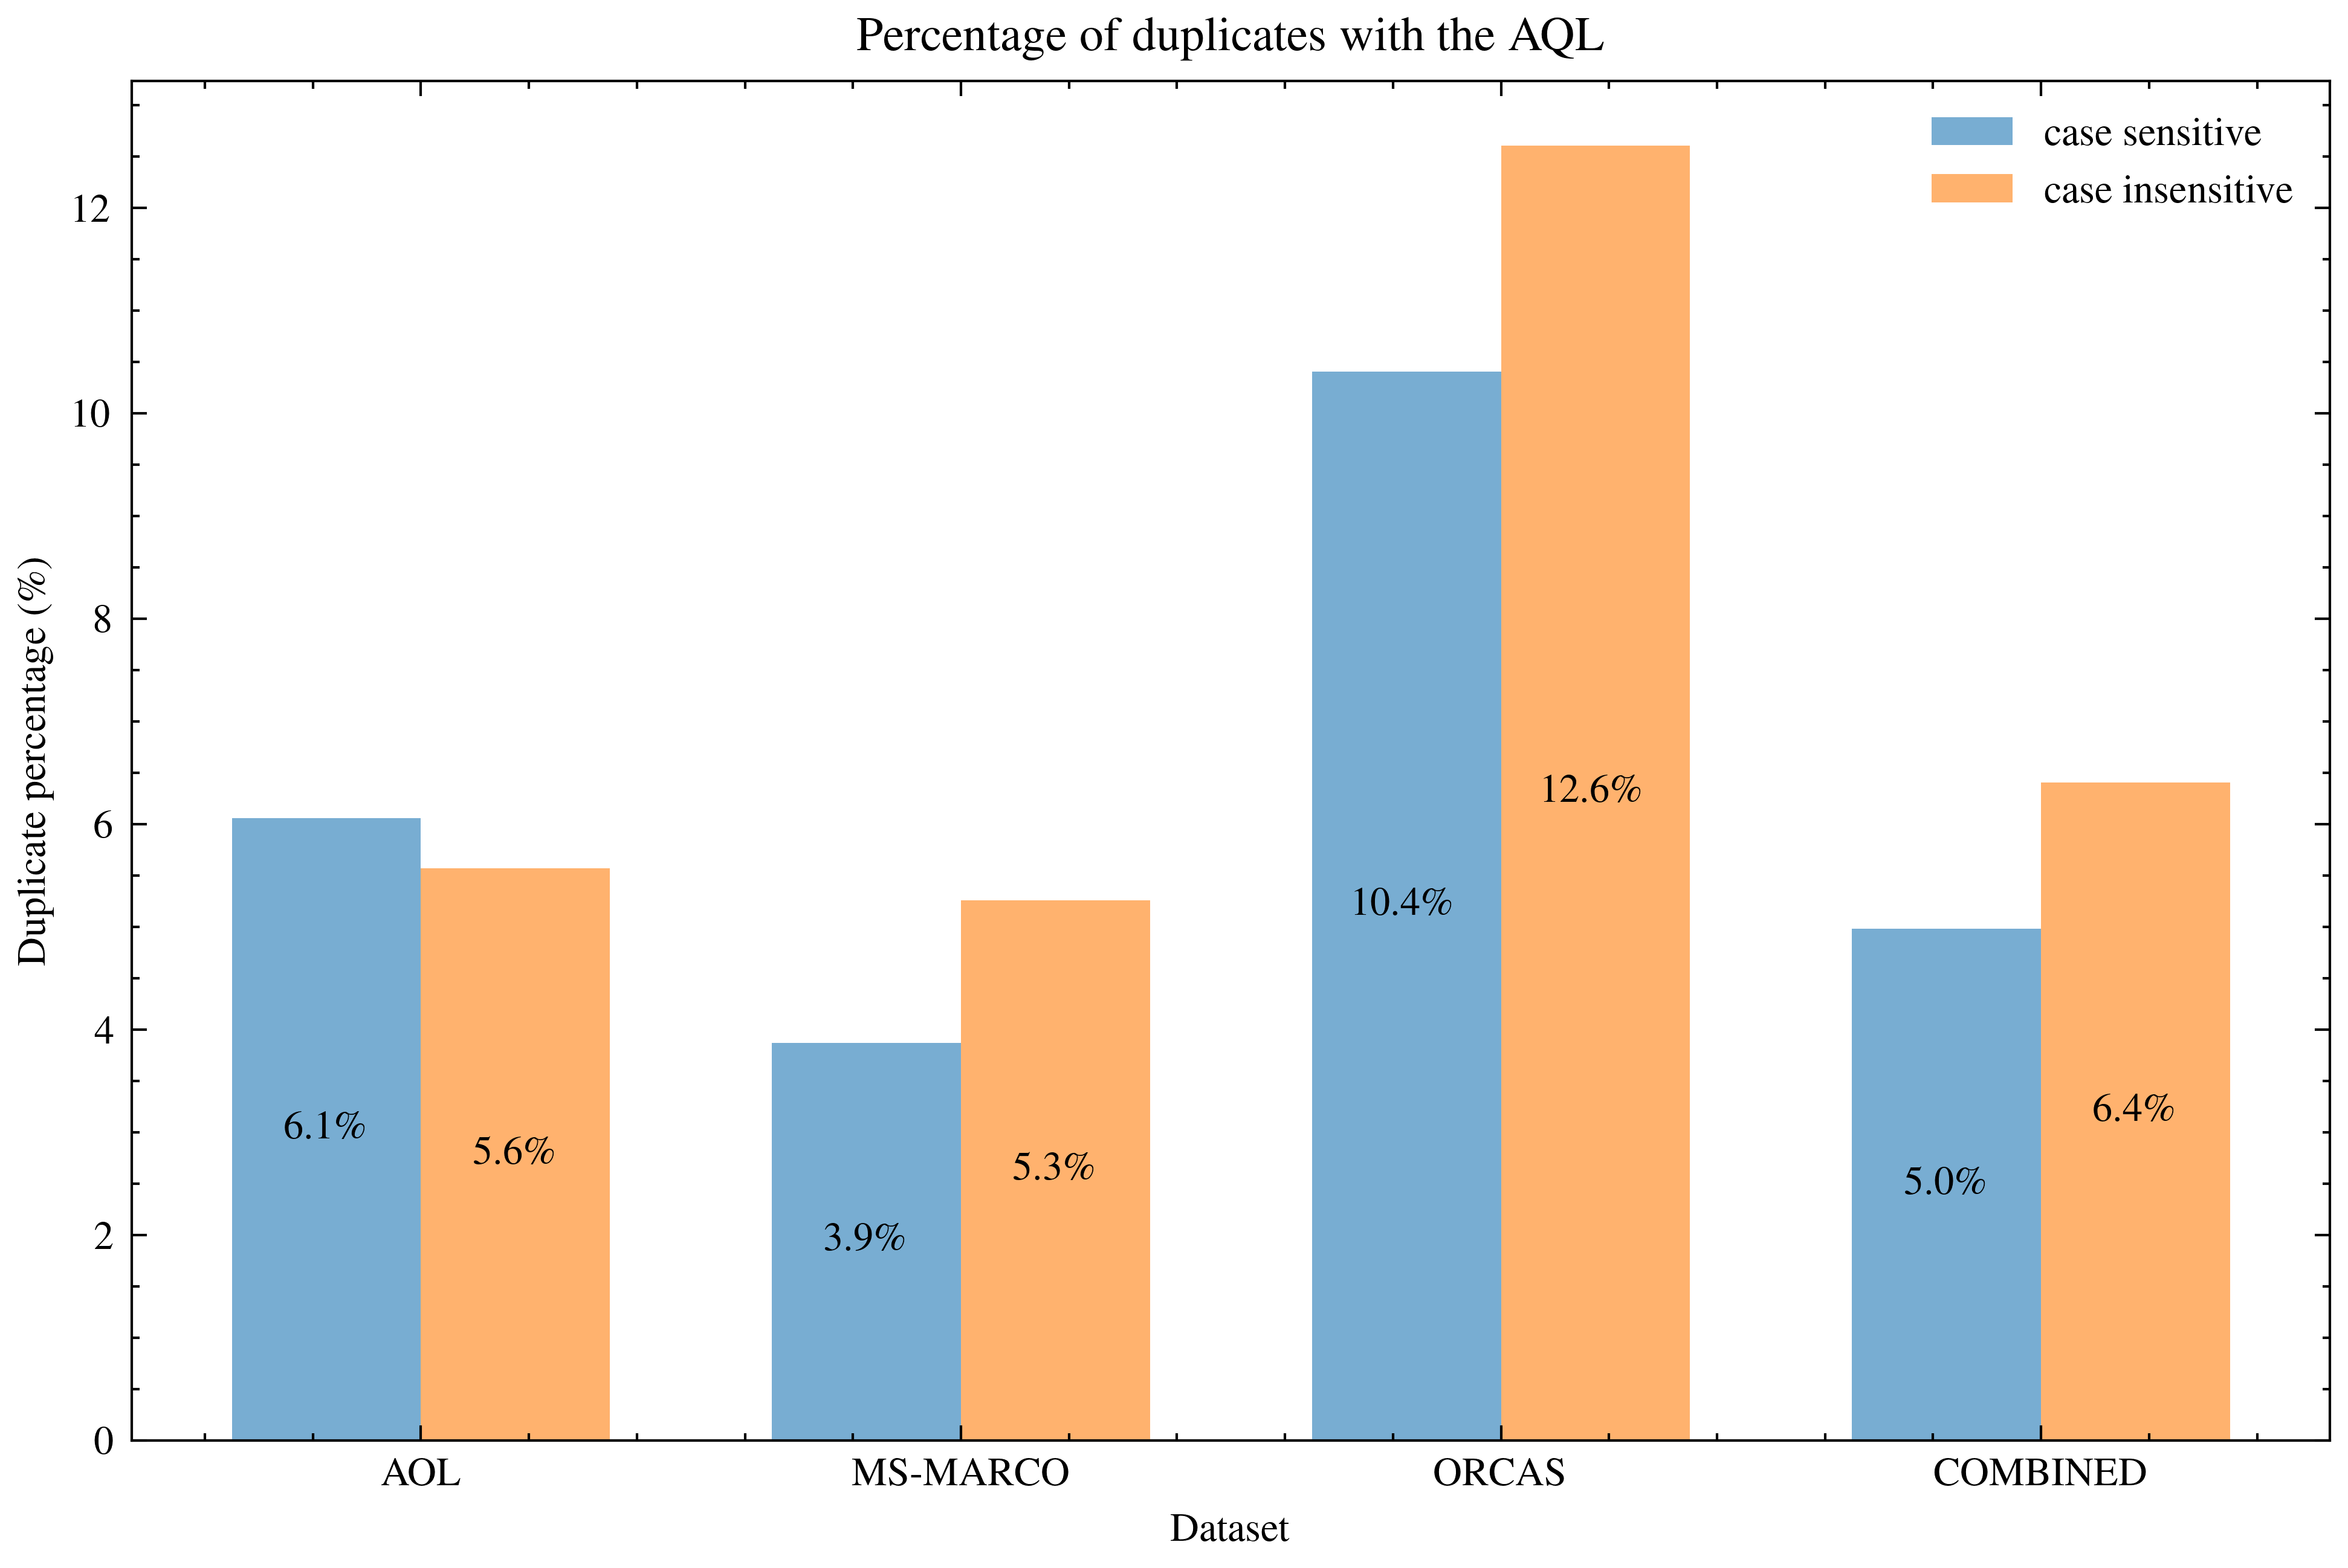

In [78]:
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
import numpy as np

assert set(analyses) == set(["count-deduplicated-lowercase-queries", "count-deduplicated-queries"]), "Unexpected analyses"
# save_plot = False
save_plot = True

plt.style.use(['science', 'ieee'])
color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.2
width = textwidth * scale
height = width * aspect_ratio * 0.9
bar_width = 0.35

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(width, height))
ax.set_title("Percentage of duplicates with the AQL")
ax.set_xlabel("Dataset")
ax.set_ylabel(r'Duplicate percentage (\%)')

# Get data for both analyses
case_sensitive_data = result_dict["count-deduplicated-queries"]
case_insensitive_data = result_dict["count-deduplicated-lowercase-queries"]

# Get common datasets
datasets = list(case_sensitive_data.keys())

# Convert to percentages
case_sensitive_values = [case_sensitive_data[dataset] * 100 for dataset in datasets]
case_insensitive_values = [case_insensitive_data[dataset] * 100 for dataset in datasets]

# Set up bar positions
x = np.arange(len(datasets))

# Create grouped bars
bars1 = ax.bar(x - bar_width/2, case_sensitive_values, bar_width, 
                label='case sensitive', color='tab:blue', alpha=0.6)
bars2 = ax.bar(x + bar_width/2, case_insensitive_values, bar_width, 
                label='case insensitive', color='tab:orange', alpha=0.6)

# Add value labels on bars
for bar, value in zip(bars1, case_sensitive_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            rf'{value:.1f}\%', ha='center', va='center', fontweight='bold', fontsize=8)
            
for bar, value in zip(bars2, case_insensitive_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2,
            rf'{value:.1f}\%', ha='center', va='center', fontweight='bold', fontsize=8)

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels([d.upper() for d in datasets])

# Add legend
ax.legend()
plt.tight_layout()

if save_plot:
    # save plot as pdf:
    folder = analyses[0]
    for an in analyses[1:]:
        folder += f"-AND-{an}"
    vis_path =  Path(f"/home/benjamin/studium/master/masterarbeit/thesis-schneg/plots/{folder}")
    print(vis_path)
    if not vis_path.exists():
        print("create new directory")
        vis_path.mkdir(parents=True)
    plt.savefig(vis_path.joinpath("plot.pdf"),format='pdf')
plt.show()

Processing dataset: aql-ms-marco
Years: [datetime.datetime(1999, 1, 1, 0, 0), datetime.datetime(1999, 12, 31, 0, 0), datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 12, 31, 0, 0), datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2001, 12, 31, 0, 0), datetime.datetime(2002, 1, 1, 0, 0), datetime.datetime(2002, 12, 31, 0, 0), datetime.datetime(2003, 1, 1, 0, 0), datetime.datetime(2003, 12, 31, 0, 0), datetime.datetime(2004, 1, 1, 0, 0), datetime.datetime(2004, 12, 31, 0, 0), datetime.datetime(2005, 1, 1, 0, 0), datetime.datetime(2005, 12, 31, 0, 0), datetime.datetime(2006, 1, 1, 0, 0), datetime.datetime(2006, 12, 31, 0, 0), datetime.datetime(2007, 1, 1, 0, 0), datetime.datetime(2007, 12, 31, 0, 0), datetime.datetime(2008, 1, 1, 0, 0), datetime.datetime(2008, 12, 31, 0, 0), datetime.datetime(2009, 1, 1, 0, 0), datetime.datetime(2009, 12, 31, 0, 0), datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2010, 12, 31, 0, 0), datetime.datetime(2011, 1, 1, 0, 0), datetime.d

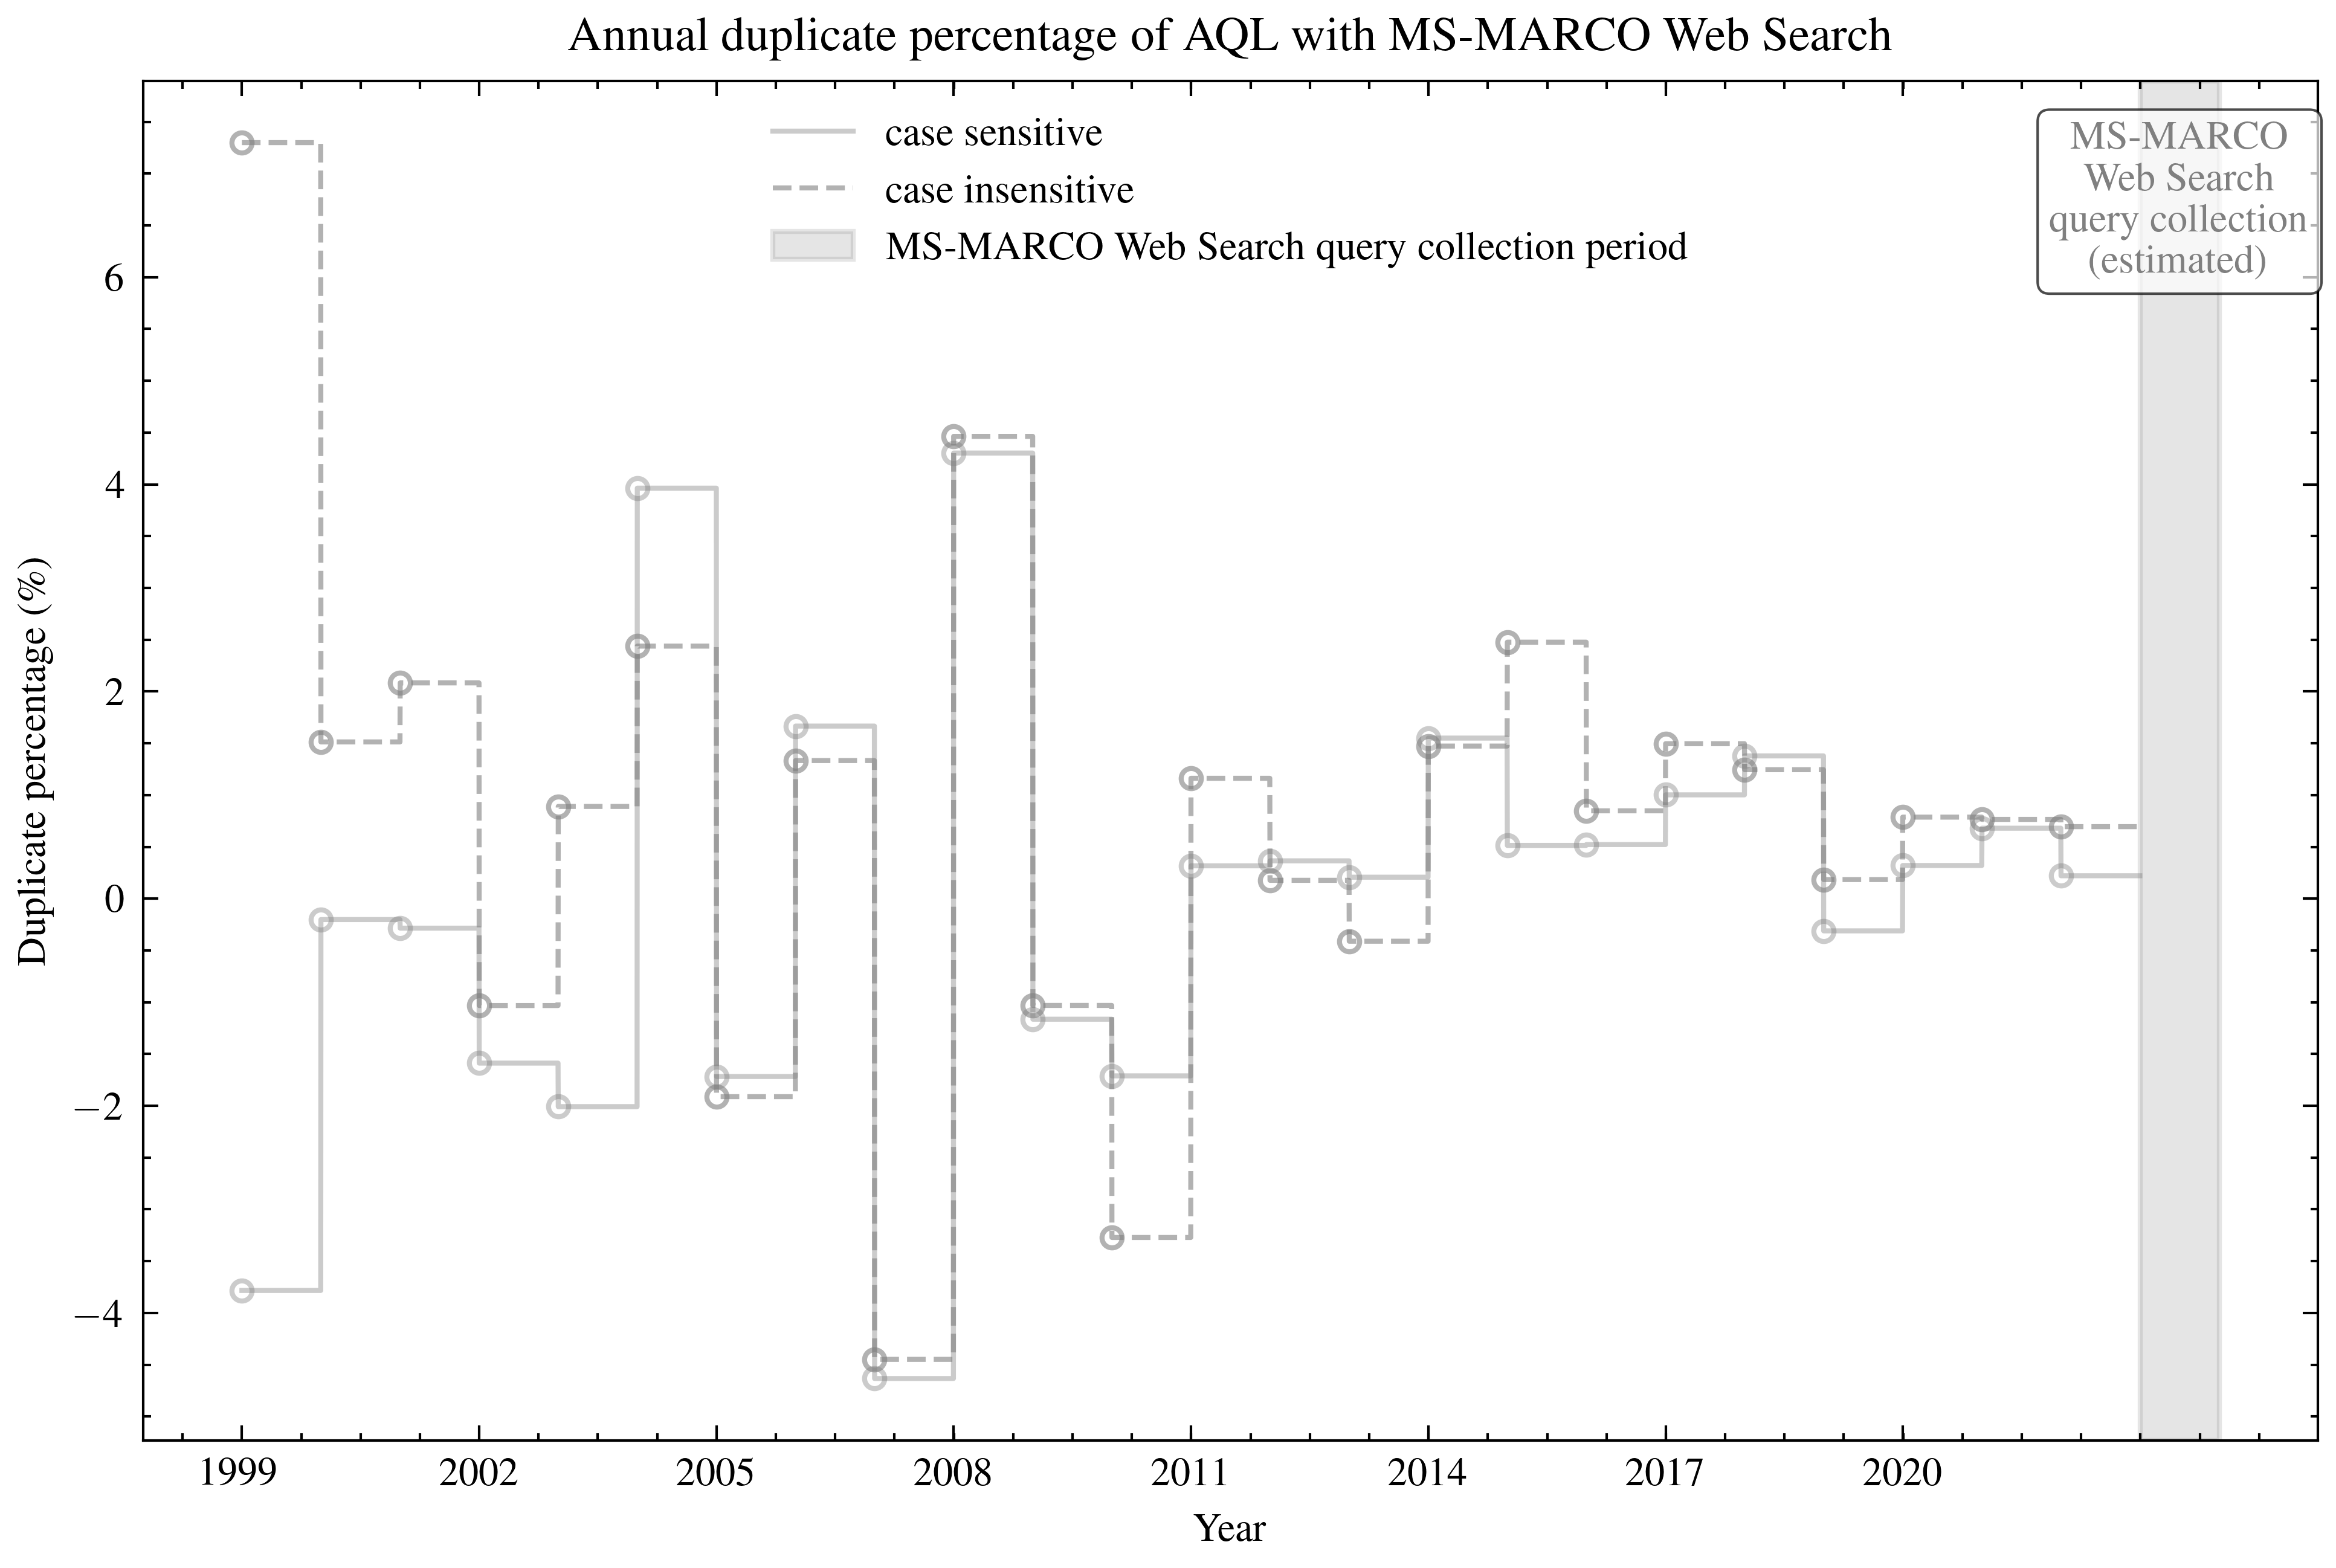

In [86]:
# for each dataset we plot the annual duplicate percentage of the AQL with the respective dataset. We do this for both case sensitive and case insensitive duplicates.
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
import numpy as np
from datetime import datetime

assert set(analyses) == set(["count-regular", "count-lowercase"]), "Unexpected analyses"

# save_plot = False
save_plot = True

datasets = []
# datasets.append('aql-aol')
datasets.append('aql-ms-marco')
# datasets.append('aql-orcas')

plt.style.use(['science', 'ieee'])
color =  {"AQL":'tab:blue', "AOL":'tab:orange', "MS-MARCO Web Search":'tab:gray', "ORCAS":'tab:red'}

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.2
width = textwidth * scale
height = width * aspect_ratio * 0.9
bar_width = 0.35


for dataset in datasets:
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(width, height))
    dataset_title = dataset.split('-')[-1].upper() if not "ms-marco" in dataset else "MS-MARCO Web Search"
    ax.set_title(f"Annual duplicate percentage of AQL with {dataset_title}")
    ax.set_xlabel("Year")
    ax.set_ylabel(r"Duplicate percentage (\%)")
    
    for i, analysis_name in enumerate(analyses):
        print(f"Processing dataset: {dataset}")
        # Here you would add the code to plot the annual duplicate percentage for the dataset
        year_nums = [year for year in result_dict[analysis_name][dataset].keys()]
        duplicate_ratios = [result_dict[analysis_name][dataset][year][0] for year in year_nums]
        
        # Create list with first and last day of each year
        years = []
        duplicate_ratios_expanded = []
        for j, year in enumerate(year_nums):
            years.append(datetime(year, 1, 1))   # First day of year
            years.append(datetime(year, 12, 31)) # Last day of year
            # Duplicate the ratio for both first and last day of each year
            duplicate_ratios_expanded.append(duplicate_ratios[j] * 100)  # Convert to percentage
            duplicate_ratios_expanded.append(duplicate_ratios[j] * 100)  # Convert to percentage
        
        # Set color based on analysis type
        label_text = 'case sensitive' if analysis_name == 'count-regular' else 'case insensitive'
        
        # Plot the complete line without markers first
        alpha_val = 0.6 if analysis_name == 'count-lowercase' else 0.4
        ax.plot(years, duplicate_ratios_expanded, 
               label=label_text, 
               color=color[dataset_title],
               linewidth=1, alpha=alpha_val)

        # Add markers only for January 1st dates (every second point in the expanded data)
        jan_1_indices = range(0, len(years), 2)  # Every second point (January 1st)
        jan_1_years = [years[i] for i in jan_1_indices]
        jan_1_ratios = [duplicate_ratios_expanded[i] for i in jan_1_indices]
        
        # Plot markers only for January 1st
        ax.plot(jan_1_years, jan_1_ratios, 
               color=color[dataset_title],
               marker='o', 
               markersize=4, 
               markerfacecolor='none',
               markeredgecolor=color[dataset_title],
               linestyle='None', alpha=alpha_val)  # No line, only markers

        print(f"Years: {years}, Duplicate Ratios: {duplicate_ratios_expanded}")
    
    # Set x-axis ticks to show only January 1st of selected years for better readability
    all_years = sorted(set(year_nums))
    # Show every 2nd or 3rd year depending on data range to avoid overcrowding
    step = 2 if len(all_years) <= 10 else 3
    selected_years = all_years[::step]
    year_ticks = [datetime(year, 1, 1) for year in selected_years]  # January 1st of selected years
    ax.set_xticks(year_ticks)
    ax.set_xticklabels([str(year) for year in selected_years])
    
    # Add data collection period as shaded area
    collection_periods = {
        'aql-aol': (datetime(2006, 3, 1), datetime(2006, 5, 31)),  # March to May 2006
        'aql-ms-marco': (datetime(2023, 1, 1), datetime(2024, 1, 1)),  # Approximate period before 2024 publication
        'aql-orcas': (datetime(2017, 11, 1), datetime(2020, 1, 31))  # 26-month period up to January 2020
    }
    
    if dataset in collection_periods:
        start_date, end_date = collection_periods[dataset]
        ax.axvspan(start_date, end_date, alpha=0.2, color='gray', label=f'{dataset_title} query collection period')
        
        # Add text label at the center of the period
        mid_date = start_date + (end_date - start_date) / 2
        ax.text(mid_date, ax.get_ylim()[1] * 0.95, f'{dataset_title}\nquery collection' if dataset_title != "MS-MARCO Web Search" else 'MS-MARCO\nWeb Search\nquery collection\n(estimated)', 
                ha='center', va='top', fontsize=8, color='gray', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7, linewidth=0.5))
    
    ax.legend()
    plt.tight_layout()
    if save_plot:
        # save plot as pdf:
        folder = analyses[0]
        for an in analyses[1:]:
            folder += f"-AND-{an}"
        vis_path =  Path(f"/home/benjamin/studium/master/masterarbeit/thesis-schneg/plots/{folder}")
        print(vis_path)
        if not vis_path.exists():
            print("create new directory")
            vis_path.mkdir(parents=True)
        plt.savefig(vis_path.joinpath(f"{dataset_title}.pdf"),format='pdf')
    plt.show()

    
            